## Imports:

* torch and torchvision for model and dataloader creation
* transforms from torchvision for Data Augmentation and Normalization
* torchmetrics for easy metric computation
* pytorch lightning for efficient and easy training implementation
* ModelCheckpoint and TensorboardLogger for checkpoint saving and logging
* tqdm for progress par when validating the model
* numpy for all kinds of stuff :)
* matplotlib for visualizing some images



In [3]:
import torch
import torchvision
from torchvision import transforms
import torchmetrics
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.loggers import TensorBoardLogger
from tqdm.notebook import tqdm
import numpy as np
import matplotlib.pyplot as plt

a transformation sequence for Data Augmentation and Normalization needed.

We use:
* RandomResizedCrops which applies a random crop of the image and resizes it to the original image size (224x224)
* Random Rotations between -5 and 5 degrees
* Random Translation (max 5%)
* Random Scaling (0.9-1.1 of original image size)

In [4]:
def load_file(path):
    return np.load(path).astype(np.float32)

In [5]:
train_transforms = transforms.Compose([
                                    transforms.ToTensor(),  # Convert numpy array to tensor
                                    transforms.Normalize(0.49, 0.248),  # Use mean and std from preprocessing notebook
                                    transforms.RandomAffine( # Data Augmentation
                                        degrees=(-5, 5), translate=(0, 0.05), scale=(0.9, 1.1)),
                                        transforms.RandomResizedCrop((224, 224), scale=(0.35, 1)) #from stackoverflow ans 

])

val_transforms = transforms.Compose([
                                    transforms.ToTensor(),  # Convert numpy array to tensor
                                    transforms.Normalize([0.49], [0.248]),  # Use mean and std from preprocessing notebook
])




Finally, we create the train and val dataset and the corresponding data loaders.

Please adapt batch size and num_workers according to your hardware ressources.

In [6]:
train_dataset = torchvision.datasets.DatasetFolder(
    "Processed/train/",
    loader=load_file, extensions="npy", transform=train_transforms)

val_dataset = torchvision.datasets.DatasetFolder(
    "Processed/val/",
    loader=load_file, extensions="npy", transform=val_transforms)


Let's inspect some augmented train images

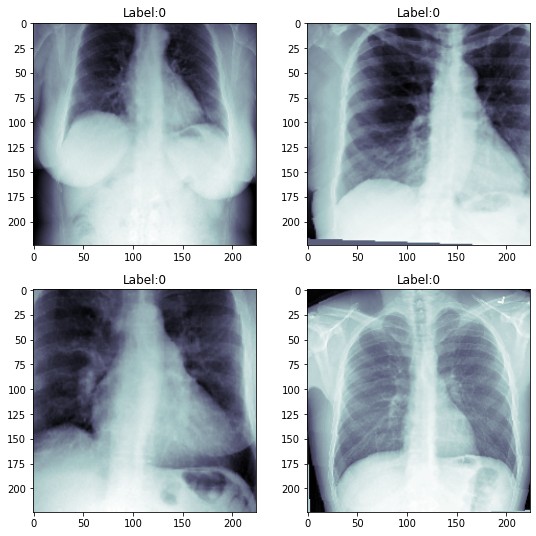

In [7]:
fig, axis = plt.subplots(2, 2, figsize=(9, 9))
for i in range(2):
    for j in range(2):
        random_index = np.random.randint(0, 20000)
        x_ray, label = train_dataset[random_index]
        axis[i][j].imshow(x_ray[0], cmap="bone")
        axis[i][j].set_title(f"Label:{label}")


In [58]:
batch_size = 10#TODO
num_workers = 0# TODO

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, num_workers=num_workers, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, num_workers=num_workers, shuffle=False)

print(f"There are {len(train_dataset)} train images and {len(val_dataset)} val images")

There are 24000 train images and 2684 val images


dataset is imbalanced , todo oversampled or weighted sampling stuffs

In [59]:
np.unique(train_dataset.targets, return_counts=True), np.unique(val_dataset.targets, return_counts=True)

((array([0, 1]), array([18593,  5407])), (array([0, 1]), array([2079,  605])))

takes super long

todo , on colab , use vpn 

adam optimizer and binarycross entropy for classification between 0 or 1 

In [60]:
class PneumoniaModel(pl.LightningModule):
    def __init__(self, weight=1):
        super().__init__()
        
        self.model = torchvision.models.resnet18()
        # change conv1 from 3 to 1 input channels
        self.model.conv1 = torch.nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        # change out_feature of the last fully connected layer (called fc in resnet18) from 1000 to 1
        self.model.fc = torch.nn.Linear(in_features=512, out_features=1)
        
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=1e-4)
        self.loss_fn = torch.nn.BCEWithLogitsLoss(pos_weight=torch.tensor([weight]))
        
        # simple accuracy computation
        self.train_acc = torchmetrics.Accuracy()
        self.val_acc = torchmetrics.Accuracy()

    def forward(self, data):
        pred = self.model(data)
        return pred
    
    def training_step(self, batch, batch_idx):
        x_ray, label = batch
        label = label.float()  # Convert label to float (just needed for loss computation)
        pred = self(x_ray)[:,0]  # Prediction: Make sure prediction and label have same shape
        loss = self.loss_fn(pred, label)  # Compute the loss
        
        # Log loss and batch accuracy
        self.log("Train Loss", loss)
        self.log("Step Train Acc", self.train_acc(torch.sigmoid(pred), label.int()))
        return loss
    
    
    def training_epoch_end(self, outs):
        # After one epoch compute the whole train_data accuracy
        self.log("Train Acc", self.train_acc.compute())
        
        
    def validation_step(self, batch, batch_idx):
        # Same steps as in the training_step
        x_ray, label = batch
        label = label.float()
        pred = self(x_ray)[:,0]  # make sure prediction and label have same shape

        loss = self.loss_fn(pred, label)
        
        # Log validation metrics
        self.log("Val Loss", loss)
        self.log("Step Val Acc", self.val_acc(torch.sigmoid(pred), label.int()))
        return loss
    
    def validation_epoch_end(self, outs):
        self.log("Val Acc", self.val_acc.compute())
    
    def configure_optimizers(self):
        #Caution! You always need to return a list here (just pack your optimizer into one :))
        return [self.optimizer]



In [61]:
model = PneumoniaModel()  # Instanciate the model

We create a checkpoint callback which only stores the 10 best models based on the validation accuracy.

In [62]:
# Create the checkpoint callback
checkpoint_callback = ModelCheckpoint(
    monitor='Val Acc',
    save_top_k=10,
    mode='max')

Trainer documentation: https://pytorch-lightning.readthedocs.io/en/latest/common/trainer.html

In [63]:
# Create the trainer
# Change the gpus parameter to the number of available gpus on your system. Use 0 for CPU training

gpus = 0 #TODO
trainer = pl.Trainer(gpus=gpus, logger=TensorBoardLogger(save_dir="./logs"), log_every_n_steps=1,
                     callbacks=checkpoint_callback,
                     max_epochs=35)


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


In [ ]:
trainer.fit(model, train_loader, val_loader)




  | Name      | Type              | Params
------------------------------------------------
0 | model     | ResNet            | 11.2 M
1 | loss_fn   | BCEWithLogitsLoss | 0     
2 | train_acc | Accuracy          | 0     
3 | val_acc   | Accuracy          | 0     
------------------------------------------------
11.2 M    Trainable params
0         Non-trainable params
11.2 M    Total params
44.683    Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

## Evaluation

Let's evaluate our model!
At first, we load the latest checkpoint and send the model to the GPU, if possible.

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Use strict=False, otherwise we would want to match the pos_weight which is not necessary
model = PneumoniaModel.load_from_checkpoint("weights/weights_1.ckpt")
model.eval()
model.to(device);

Compute prediction on the complete validation set and store predictions and labels

In [ ]:
preds = []
labels = []

with torch.no_grad():
    for data, label in tqdm(val_dataset):
        data = data.to(device).float().unsqueeze(0)
        pred = torch.sigmoid(model(data)[0].cpu())
        preds.append(pred)
        labels.append(label)
preds = torch.tensor(preds)
labels = torch.tensor(labels).int()


Compute metrics:
We can see that the overall result is already decent with our simple model.<br />
However, we suffer from a large amount of False Negatives due to the data imbalance.<br />
This is of particular importance in to avoid in medical imaging as missing findings might be fatal.<br />
Feel free to try what happens if you increase or decrease the weight in the loss.

An alternative to retraining with a weighted loss is to reduce the classification threshold from 0.5 to e.g 0.25. It produces way less false negatives but increases the number of False positives. <br />
This is called the precision-recall tradeoff

In [ ]:
acc = torchmetrics.Accuracy()(preds, labels)
precision = torchmetrics.Precision()(preds, labels)
recall = torchmetrics.Recall()(preds, labels)
cm = torchmetrics.ConfusionMatrix(num_classes=2)(preds, labels)
cm_threshed = torchmetrics.ConfusionMatrix(num_classes=2, threshold=0.25)(preds, labels)

print(f"Val Accuracy: {acc}")
print(f"Val Precision: {precision}")
print(f"Val Recall: {recall}")
print(f"Confusion Matrix:\n {cm}")
print(f"Confusion Matrix 2:\n {cm_threshed}")

In [ ]:
fig, axis = plt.subplots(3, 3, figsize=(9, 9))

for i in range(3):
    for j in range(3):
        rnd_idx = np.random.randint(0, len(preds))
        axis[i][j].imshow(val_dataset[rnd_idx][0][0], cmap="bone")
        axis[i][j].set_title(f"Pred:{int(preds[rnd_idx] > 0.5)}, Label:{labels[rnd_idx]}")
        axis[i][j].axis("off")


Congratulation! You made it to the end of the notebook and to the end of the classification lecture.